# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [23]:
#
#Step1: clean dataset. 
#    The dataset contains detailed information about hundreds of thousands of used car sales. 
#    We can prepare some important questions to help us better understand the data.
#Questions to answer:
#Are there features that have a strong correlation or no correlation with price?
#Unfortunately the data has few ‘continuous’ values to begin with. This will be addressed below. With the only continuous values being id, price, year, and odometer reading very little was gleaned. With that said there appears to be little correlation with id and some correlation with odometer.
#Are there features with exclusively one particular value?
#Title_status is almost exclusively ‘clean’. Possibly drop this column since it likely can’t provide meaning.
#Are there features with missing values?
#Some columns have many missing values and these will need to be addressed on a case by case basis. In some cases if there are not many missing values they might be dropped from the dataset.
#Are there categorical features that need to be encoded?
#This dataset has many categorical features; some of them will need to be one-hot encoded(ie Fuel), while other might be converted to ordinal values(ie Condition). Some of the categorical features with many different values might have to be addressed in a more unique way on a case by case basis.
#Looking at the data the biggest question remains that price does not necessarily equate with profits. It would be helpful to collect data on the price the dealers purchased the cars for to be able to see which cars produced more profits.

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, ARDRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import io

In [15]:
df = pd.read_csv('/Users/jayakanthjayaram/Downloads/practical_application_II_starter/data/vehicles.csv')

In [16]:
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)

           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2 

In [17]:
n = df.nunique(axis=0)
print("No.of.unique values in each column :\n",n)

No.of.unique values in each column :
 id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64


In [18]:
print(df['paint_color'].unique())
print(df['region'].value_counts())

[nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64


In [19]:
#Several columns have to be dropped and have missing values dealt with
#drop the following columns
df.drop(columns = ['id', 'title_status', 'VIN', 'model', 'size', 'region'], inplace = True )
#drop nan avalues for manufacturer
df['manufacturer'].dropna(inplace = True)
df['year'].fillna(df['year'].median(), inplace = True)
df['fuel'].fillna(df['fuel'].value_counts().index[0], inplace = True)
df['odometer'].fillna(df['odometer'].mean(), inplace = True)
df['transmission'].fillna(df['transmission'].value_counts().index[0], inplace = True)
df['paint_color'].fillna(df['paint_color'].value_counts().index[0], inplace = True)
df = df[df['cylinders'] != 'other']
df['cylinders'].fillna(0, inplace = True)
df = df[df['drive'].notna()]
df = df[df['manufacturer'].notna()]
df = df[df['type'].notna()]
df.drop(df[df['price'] == 0].index, inplace = True)
df.drop(df[df['price'] > 100000].index, inplace = True)


In [20]:
df.drop(df[df['year'] < 1990].index, inplace = True)
df.drop(df[df['odometer'] > 200000].index, inplace = True)
df.dropna(inplace = True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144871 entries, 31 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  object 
 3   condition     144871 non-null  object 
 4   cylinders     144871 non-null  object 
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  object 
 10  paint_color   144871 non-null  object 
 11  state         144871 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 14.4+ MB


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

/Users/jayakanthjayaram/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


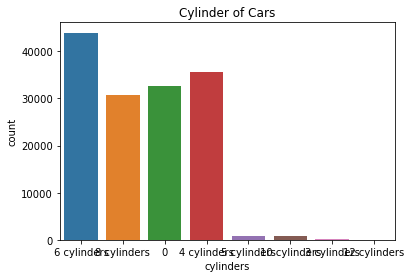

In [24]:
fig = sns.countplot(df.cylinders)
fig.title.set_text("Cylinder of Cars")

In [25]:
# take a random sample from dataset and make a plot
df3 = df[['price', 'year', 'odometer']]
df_sample = df3.sample(n = 100, random_state = 1)
df_sample.head()

,price,year,odometer
194594,18995,2017.0,43406.0
145771,19995,2013.0,145207.0
175158,17990,2017.0,20909.0
52019,11338,2014.0,101905.0
166818,22999,2007.0,80466.0


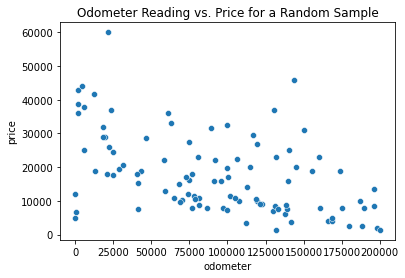

In [26]:
sns.scatterplot(x = 'odometer', y = 'price', data = df_sample)
plt.title("Odometer Reading vs. Price for a Random Sample")
plt.show()

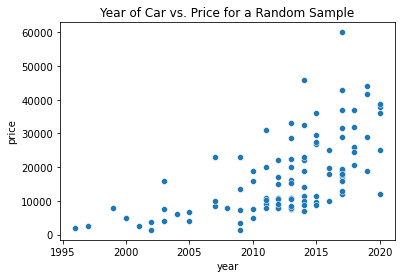

In [27]:
sns.scatterplot(x = 'year', y = 'price', data = df_sample)
plt.title("Year of Car vs. Price for a Random Sample")
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Text(0, 0.5, 'Number of Cars')

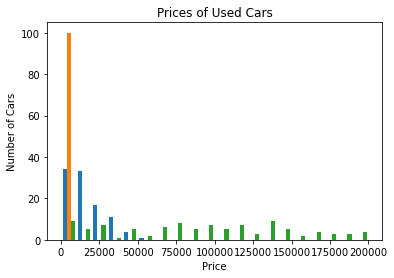

In [29]:
plt.hist(df_sample, bins = 20)
plt.title("Prices of Used Cars")
plt.xlabel("Price")
plt.ylabel("Number of Cars")

Text(0, 0.5, 'Number of Cars')

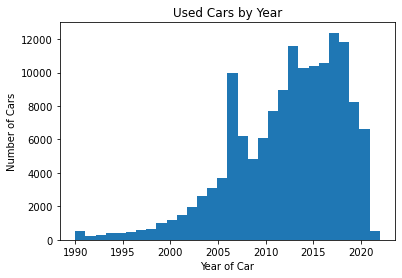

In [30]:
plt.hist(df.year, bins = 30)
plt.title("Used Cars by Year")
plt.xlabel('Year of Car')
plt.ylabel('Number of Cars')

/Users/jayakanthjayaram/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


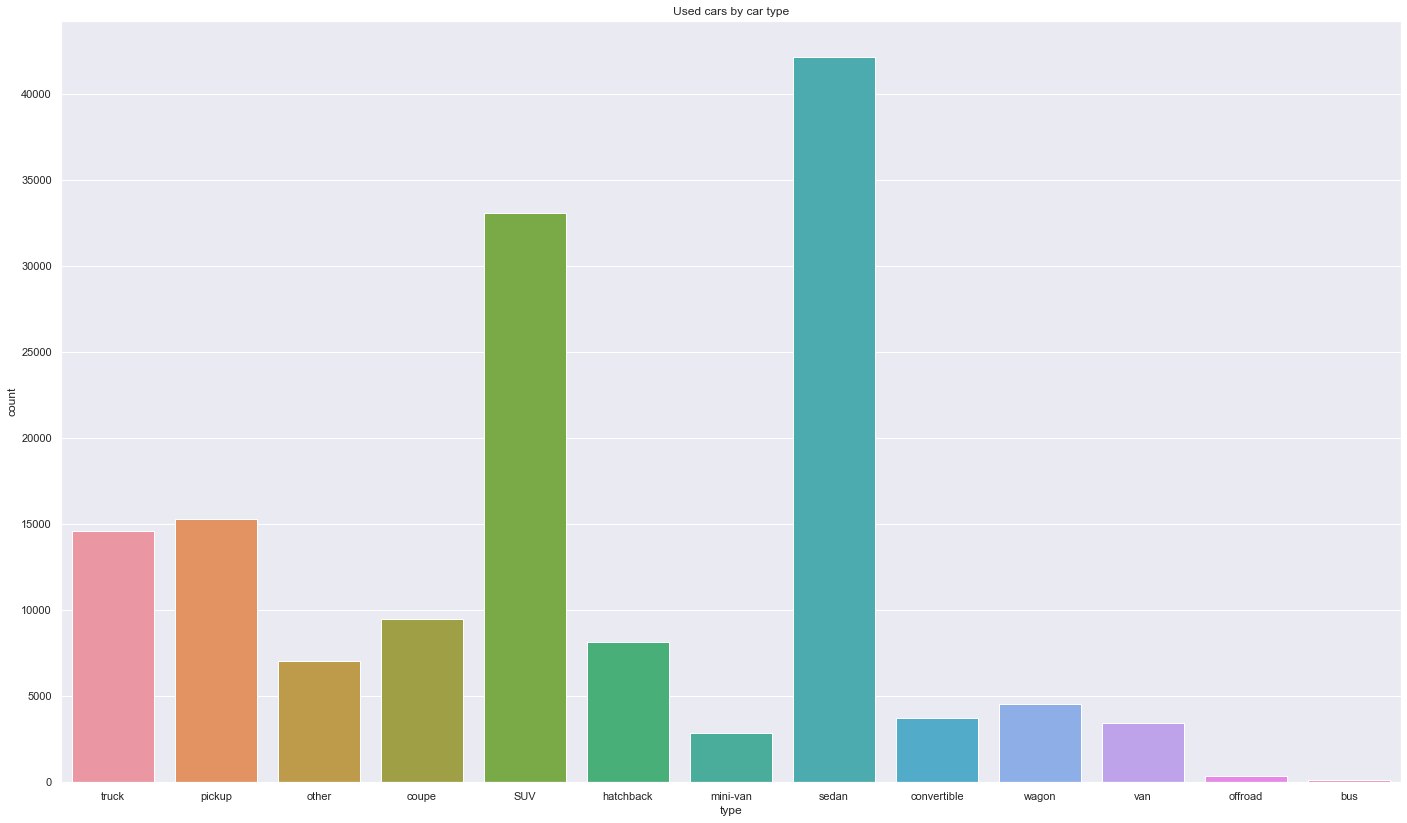

In [31]:
sns.set(rc={'figure.figsize':(24,14)})
fig2 = sns.countplot(df.type)
fig2.title.set_text('Used cars by car type')

In [32]:
## Decision made to only create dummy columns for features with minimal unique values. 
df2 = pd.get_dummies(df,columns = ['fuel', 'transmission', 'drive'])
df2 = df.reset_index()
df2.info(verbose = True)
df2.drop(columns = 'index', inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   index         144871 non-null  int64  
 1   price         144871 non-null  int64  
 2   year          144871 non-null  float64
 3   manufacturer  144871 non-null  object 
 4   condition     144871 non-null  object 
 5   cylinders     144871 non-null  object 
 6   fuel          144871 non-null  object 
 7   odometer      144871 non-null  float64
 8   transmission  144871 non-null  object 
 9   drive         144871 non-null  object 
 10  type          144871 non-null  object 
 11  paint_color   144871 non-null  object 
 12  state         144871 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 14.4+ MB


In [33]:
# Label encode columns with many unique values.  This is less than ideal but necessary without far more time and computing power.
from sklearn.preprocessing import LabelEncoder
labeled_cols = ['manufacturer', 'paint_color', 'state', 'type']
df2[labeled_cols] = df2[labeled_cols].apply(LabelEncoder().fit_transform)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  int64  
 3   condition     144871 non-null  object 
 4   cylinders     144871 non-null  object 
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  int64  
 10  paint_color   144871 non-null  int64  
 11  state         144871 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 13.3+ MB


In [36]:
# Ordinal Encoding for Condition Feature
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
condition = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
enc = OrdinalEncoder(categories = [condition], dtype = int)
df2['condition'] = enc.fit_transform(df[['condition']])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  int64  
 3   condition     144871 non-null  int64  
 4   cylinders     144871 non-null  object 
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  int64  
 10  paint_color   144871 non-null  int64  
 11  state         144871 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 13.3+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [37]:
# Features and Target
features = df2.drop(columns = ['price'])
features.head()
price = df2.price
price.head()

0    15000
1    27990
2    34590
3    35000
4    29990
Name: price, dtype: int64

In [39]:
# Start with a simple Linear Regression Model with just 2 features
features2 = df2[['odometer', 'year']]
price = df2['price']
f2 = LinearRegression(fit_intercept = True)
f2.fit(features2, price)
linreg_mse = mean_squared_error(f2.predict(features2), price)
print(linreg_mse)

98884090.80131195


In [40]:
# checking the correlation between price and other features
pd.set_option('display.max_rows', 200)
price_corr = df2.corrwith(df2['price'])
print(price_corr)

price           1.000000
year            0.573961
manufacturer   -0.048122
condition      -0.058223
odometer       -0.579189
type            0.044952
paint_color     0.042844
state          -0.015047
dtype: float64


In [43]:
#scale the data
object = StandardScaler()
features_scaled = df2[['odometer', 'year']]
print(type(features))
print(type(features_scaled))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [44]:
#Cross validation
# Create testing and training data
X = features_scaled
y = price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [46]:
#Linear REgression
# Start with a simple Linear Regression Model with just 2 features
features2 = df2[['odometer', 'year']]
price = df2['price']
f2 = LinearRegression(fit_intercept = True)
f2.fit(features2, price)
linreg_mse = mean_squared_error(f2.predict(features2), price)
print(linreg_mse)

98884090.80131195


In [47]:
# Create testing and training data
X = features_scaled
y = price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)
print(type(X))

<class 'pandas.core.frame.DataFrame'>


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
#With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this. We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices. Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#Modeling was a bit more challenging than expected. Since a few of the columns lended themselves to one hot encoding it created a dataframe with far too many columns than was able to be processed with a home laptop. With this restriction in mind a dataframe that was limited to 20 columns with several of the columns labeled in a less than ideal manner. The modeling produced inconsistent results as the errors were rather large. Overall, it was apparent that the features that had the most positive impact on price was the lower odometer readings, newer cars, and more cylinders. Some other features seemed to also play a part. While I could certainly recommend that automatic transmissions are recommended and preferred by buyers over other transmissions, I would not feel overly confident providing any other valuable insights with the data collected and analyzed thus far. I would recommend collecting more data that correlated more with price. As we’ve seen from previous studies it might be possible to collect data on horsepower, fuel efficiency, or other metrics that might be correlated better with price. Another fault of this whole process is that it’s unclear which types of cars provide the most profit vs. just which cars sell for the most. This would be essential in making suggestions to used car dealers. It might be possible that cheaper cars sell more frequently and provide more profit but it is hard to make that conclusion from the current data.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [48]:
#Based upon collecting, organizing, and analyzing the data provided in order to give insight into how to maximize profits with the sale of used cars we can provide some insight but would also feel more comfortable collecting more data and providing further analysis. Most essentially, it would be very helpful to know the profits made on previous car sales. This could be found by keeping track of the price paid for the used cars by the dealers. But, with the data currently accessible a few things are clear: Used car buyers pay more for cars that are newer and thus have lower odometer readings.
#Used car buyers pay more for cars with automatic transmissions. Be very wary in using inventory with other types of transmissions. Used car buyers will pay more for electric and hybrid vehicles thus it is recommended to have these types of vehicles available for purchase. While other factors certainly contribute to the overall price and customer interest these variables vary wildly and it can not be fully ascertained at this time as to which factors would ultimately be influential in more profits. It is therefore recommended that we continue collecting data on what other features of used cars would contribute to customer interest and thus more profits. With that data we can likely create better models to predict what the future may hold.